In [65]:
#%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import pyxem as pxm
from matplotlib import cm
from skimage.feature import blob_log
from sklearn.cluster import DBSCAN

In [64]:
import sklearn

In [8]:
dp_raw = pxm.load('200625A17-scan.blo')
data = dp_raw.data

# Features of matrix and precipitates

In [41]:
pos_mat1 = [60,66]
pos_mat2 = [144,36]
pos_pre1 = [109,126]
pos_pre2 = [61,203]
peaks_mat1 = blob_log(data[pos_mat1[0], pos_mat1[1]],min_sigma=3,max_sigma=30,num_sigma=20,threshold=0.1)
peaks_mat2 = blob_log(data[pos_mat2[0], pos_mat2[1]],min_sigma=3,max_sigma=30,num_sigma=10,threshold=0.1)
peaks_pre1 = blob_log(data[pos_pre1[0], pos_pre1[1]],min_sigma=3,max_sigma=30,num_sigma=10,threshold=0.1)
peaks_pre2 = blob_log(data[pos_pre2[0], pos_pre2[1]],min_sigma=3,max_sigma=30,num_sigma=10,threshold=0.1)

/u/wangnisn/.local/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/u/wangnisn/.local/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/u/wangnisn/.local/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/u/wangnisn/.local/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


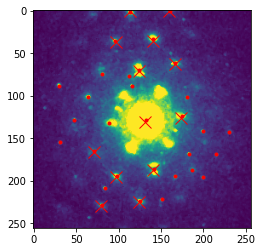

In [42]:
plt.imshow(data[pos_pre2[0],pos_pre2[1]],cmap=cm.viridis)
plt.plot(peaks_mat1[:,1], peaks_mat1[:,0],'rx', markersize=12)
plt.plot(peaks_pre2[:,1], peaks_pre2[:,0],'ro', markersize=3)

# Segmentation

to seperate matrix and pricipitates

In [44]:
#%%time
#shape = data.shape
#num_peaks_matrix = np.zeros((shape[0],shape[1]))
#for i in range(shape[0]):
#    for j in range(shape[1]):
#        print (i,j)
#        peaks = blob_log(data[i,j],min_sigma=3,max_sigma=30,num_sigma=10,threshold=0.1)
#        num_peaks_matrix[i,j] = len(peaks)
#np.save('num_peaks_matrix',num_peaks_matrix)

In [45]:
num_peaks_matrix = np.load('num_peaks_matrix.npy')

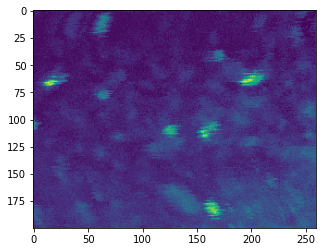

In [46]:
plt.imshow(num_peaks_matrix,cmap=cm.viridis)

Use the threshold to get pixels in precipitates and pixels in matrix

In [157]:
threshold_pre = 0.65*np.max(num_peaks_matrix)
threshold_mat = 0.35*np.max(num_peaks_matrix)
mask_pre = num_peaks_matrix > threshold_pre
mask_mat = num_peaks_matrix < threshold_mat

plot selected precipitates

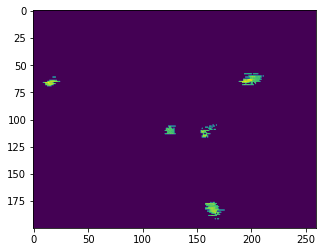

In [158]:
plt.imshow( num_peaks_matrix*mask_pre ,cmap=cm.viridis)

plot selected matrix

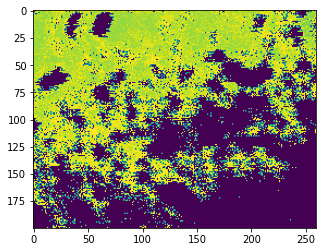

In [159]:
plt.imshow( num_peaks_matrix*mask_mat ,cmap=cm.viridis)

get diffraction pattern of the matrix

In [165]:
pos_mat = np.argwhere(mask_mat == True)
diff_pattern_mat = np.mean(data[pos_mat[:,0],pos_mat[:,1]],axis=0)

Text(0.5, 1.0, 'Diffraction pattern of matrix')

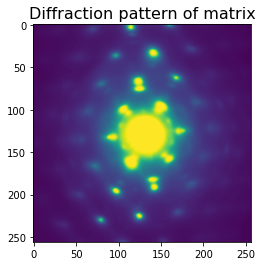

In [170]:
plt.imshow(diff_pattern_mat, cmap=cm.viridis)
plt.title('Diffraction pattern of matrix',fontsize=16)

In [160]:
positions = np.argwhere(mask == True)

In [208]:
model = DBSCAN(eps=5,min_samples=10)
model.fit(positions)
labels = model.labels_
core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
num_precipitates = n_clusters_
n_noise_ = list(labels).count(-1)

print('Estimated number of precipitates: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of precipitates: 5
Estimated number of noise points: 0


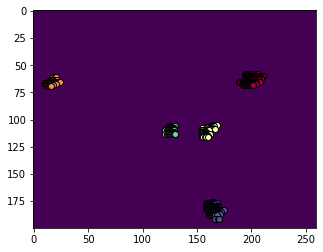

In [162]:
plt.imshow( num_peaks_matrix*mask ,cmap=cm.viridis)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        #col = [0, 0, 0, 1]
        continue

    class_member_mask = (labels == k)
    xy = positions[class_member_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    #xy = positions[class_member_mask & core_samples_mask]
    #plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=14)
    #xy = positions[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=6)

In [163]:
diff_pattern_pres = []
positions_pres = []
for i in range(n_clusters_):
    class_member_mask = (labels == i)
    xy = positions[class_member_mask]
    center = np.mean(xy,axis=0)
    pattern = np.mean(data[xy[:,0],xy[:,1]],axis=0)
    diff_pattern_pres.append(pattern)
    positions_pres.append(center)

plot diffraction patterns of precipitates

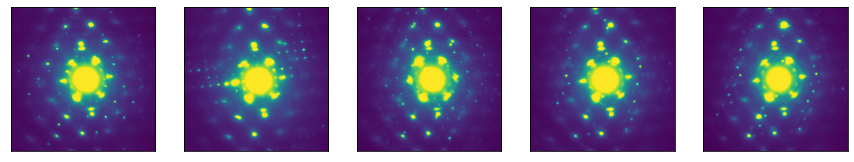

In [164]:
fig, ax = plt.subplots(1,n_clusters_,figsize=(15,5))
for i in range(n_clusters_):
    ax[i].imshow(diff_pattern_pres[i],cmap=cm.viridis)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Eliminate peaks of matrix

In the diffraction pattern of precipitates, diffraction peaks of matrix are also present. We use a simple method to eliminate them

first, find the peaks in diffracion pattern of matrix

In [205]:
peaks_mat = blob_log(diff_pattern_mat,min_sigma=3,max_sigma=30,num_sigma=20,threshold=20)

/u/wangnisn/.local/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/u/wangnisn/.local/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/u/wangnisn/.local/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/u/wangnisn/.local/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


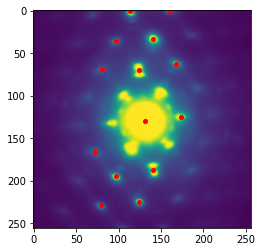

In [206]:
plt.imshow(diff_pattern_mat, cmap=cm.viridis)
plt.plot(peaks_mat[:,1],peaks_mat[:,0],'ro',markersize=4)

In [256]:
def eliminate_peak(image,positions,radii,gaussian_valley_min=0.1,method='threshold'):
    """
    positions............2D numpy array of shape (n_positions, 2)
                         list of peak positions
    gaussian_valley_min..float, the minimum value of the gaussian valley function.
                         the maximum value is always 1.
    """
    positions = np.array(positions)
    if not len(positions.shape) == 2:
        raise ValueError('positions must be 2D array')
    if not (len(positions) == len(radii)):
        raise ValueError('length of radii and positions must be identical')
    shape = image.shape
    x_mesh, y_mesh = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    x_mesh = x_mesh.flatten()
    y_mesh = y_mesh.flatten()
    pos_pixels = np.vstack([x_mesh, y_mesh]).T
    image_filtered = image.copy()
    for position,radius in zip(positions,radii):
        dist_square = np.sum((pos_pixels - position)*(pos_pixels-position),axis=1)
        gfilter =  (1.-(1.-gaussian_valley_min)*np.exp(-dist_square/(2*radius**2)))
        gfilter = np.reshape(gfilter, shape)
        image_filtered = image_filtered*gfilter
    return image_filtered

method 1: use gaussian valley function to attenuate peaks of matrix

In [259]:

diff_pattern_pres_eli = []
for i in range(num_precipitates):
    pattern = eliminate_peak(diff_pattern_pres[i], positions=peaks_mat[:,0:2],radii=4*peaks_mat[:,2],gaussian_valley_min=0.1)
    diff_pattern_pres_eli.append(pattern)

plot diffraction patterns of precipitates after eliminating peaks of matrix

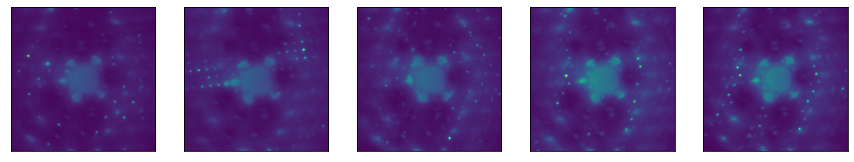

In [260]:
fig, ax = plt.subplots(1,n_clusters_,figsize=(15,5))
for i in range(num_precipitates):
    ax[i].imshow(diff_pattern_pres_eli[i]/np.max(diff_pattern_pres_eli[i])*255,cmap=cm.viridis)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

method 2: simple substraction

In [261]:
diff_pattern_pres_eli_2 = []
for i in range(num_precipitates):
    pattern = diff_pattern_pres[i] - diff_pattern_mat
    diff_pattern_pres_eli_2.append(pattern)

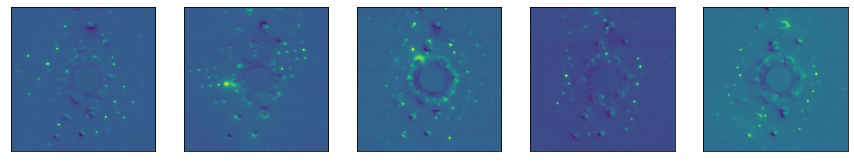

In [262]:
fig, ax = plt.subplots(1,n_clusters_,figsize=(15,5))
for i in range(num_precipitates):
    ax[i].imshow(diff_pattern_pres_eli_2[i]/np.max(diff_pattern_pres_eli[i])*255,cmap=cm.viridis)
    ax[i].set_xticks([])
    ax[i].set_yticks([])